# NYC Real Estate Uncertainty Estimator

Automated estimator that outputs **Aleatoric** (data noise) and **Epistemic** (model doubt) uncertainty for NYC property prices, with LLM-based feature engineering and SHAP interpretability.

## Phase 1 — Live Data Ingestion

Load NYC Citywide Rolling Calendar Sales CSV, clean SALE PRICE, square footage, derive building age, drop duplicates.

In [6]:
print("Hello, world!")

Hello, world!


In [ ]:
!pip install seaborn    
!pip install tensorflow
!pip install shap
!pip install matplotlib
!pip install pandas
!pip install numpy


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
!pip install scikit-learn


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import os
import json
import random
import numpy as np
import pandas as pd
if os.environ.get("CI"):
    import matplotlib
    matplotlib.use("Agg")
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.filterwarnings("ignore")

In [305]:
df_raw = "NYC_Citywide_Rolling_Calendar_Sales.csv"
df_raw = pd.read_csv(df_raw)
df_raw.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,376,43,NaN,S1,743 EAST 6 STREET,NaN,...,1.0,1.0,2.0,"2,090",3680.0,1940.0,1,S1,0,01/23/2025
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,372,9,NaN,C7,272 EAST 3 STREET,NaN,...,8.0,1.0,9.0,"2,021",7129.0,1900.0,2,C7,0,12/15/2025
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,372,19,NaN,C7,"292 EAST 3 STREET, 4B",NaN,...,9.0,1.0,10.0,"2,401",6920.0,1920.0,2,C7,0,02/07/2025
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,376,41,NaN,C4,"745 EAST 6TH STREET, 1B",NaN,...,28.0,0.0,28.0,"4,542",18254.0,1900.0,2,C4,540000,12/17/2025
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,385,38,NaN,C4,"21-23 AVENUE C, 5B",NaN,...,20.0,2.0,22.0,"3,315",17160.0,1900.0,2,C4,0,11/11/2025


In [ ]:
# removing unnecessary columns 
df_raw.drop(['Unnamed: 0','ADDRESS','EASE-MENT','APARTMENT NUMBER','SALE DATE','NEIGHBORHOOD','BUILDING CLASS AT PRESENT','BUILDING CLASS AT TIME OF SALE'],inplace=True, axis=1)
df_raw.head()

In [306]:
def clean_numeric(ser, remove_commas=True):
    """Coerce to numeric, handling commas and empty strings."""
    if remove_commas:
        ser = ser.astype(str).str.replace(",", "", regex=False)
    return pd.to_numeric(ser, errors="coerce")

# Clean SALE PRICE: strip $/commas, cast to float
df = df_raw.copy()
df["SALE PRICE"] = clean_numeric(df["SALE PRICE"])
df = df[df["SALE PRICE"] > 0].copy()  # Drop $0 sales (transfers)

# Clean GROSS SQUARE FEET and LAND SQUARE FEET
df["GROSS SQUARE FEET"] = clean_numeric(df["GROSS SQUARE FEET"])
df["LAND SQUARE FEET"] = clean_numeric(df["LAND SQUARE FEET"])
df = df[(df["GROSS SQUARE FEET"] > 0) & (df["LAND SQUARE FEET"] > 0)].copy()

# Derive BUILDING AGE
df["YEAR BUILT"] = pd.to_numeric(df["YEAR BUILT"], errors="coerce")
df = df[df["YEAR BUILT"].between(1800, 2025)].copy()
df["BUILDING_AGE"] = 2025 - df["YEAR BUILT"]

# Drop duplicates
df = df.drop_duplicates()

print(f"After cleaning: {len(df):,} rows")
print(df[["SALE PRICE", "GROSS SQUARE FEET", "BUILDING_AGE", "BOROUGH", "NEIGHBORHOOD"]].head())

After cleaning: 23,029 rows
    SALE PRICE  GROSS SQUARE FEET  BUILDING_AGE  BOROUGH   NEIGHBORHOOD
3       540000            18254.0         125.0        1  ALPHABET CITY
7       280000             6875.0         125.0        1  ALPHABET CITY
8      8800000             7166.0         125.0        1  ALPHABET CITY
9      2000000             7810.0         125.0        1  ALPHABET CITY
11     4000000             6990.0         125.0        1  ALPHABET CITY


In [307]:
df.isnull().sum()

BOROUGH                               0
NEIGHBORHOOD                          0
BUILDING CLASS CATEGORY               0
TAX CLASS AT PRESENT                  0
BLOCK                                 0
LOT                                   0
EASE-MENT                         23029
BUILDING CLASS AT PRESENT             0
ADDRESS                               0
APARTMENT NUMBER                  22969
ZIP CODE                              0
RESIDENTIAL UNITS                     0
COMMERCIAL UNITS                      0
TOTAL UNITS                           0
LAND SQUARE FEET                      0
GROSS SQUARE FEET                     0
YEAR BUILT                            0
TAX CLASS AT TIME OF SALE             0
BUILDING CLASS AT TIME OF SALE        0
SALE PRICE                            0
SALE DATE                             0
BUILDING_AGE                          0
dtype: int64

In [308]:
df.drop(columns = ['EASE-MENT','APARTMENT NUMBER'])

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,BUILDING_AGE
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,376,41,C4,"745 EAST 6TH STREET, 1B",10009.0,28.0,0.0,28.0,4542.0,18254.0,1900.0,2,C4,540000,12/17/2025,125.0
7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,400,11,C4,"510 EAST 5TH STREET, 9",10009.0,18.0,0.0,18.0,2404.0,6875.0,1900.0,2,C4,280000,04/29/2025,125.0
8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,400,54,C7,207 EAST 4 STREET,10009.0,8.0,3.0,11.0,2364.0,7166.0,1900.0,2,C7,8800000,11/20/2025,125.0
9,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,36,C4,106 AVENUE B,10009.0,8.0,2.0,10.0,1919.0,7810.0,1900.0,2,C4,2000000,03/13/2025,125.0
11,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,404,42,C4,327 EAST 10 STREET,10009.0,10.0,0.0,10.0,2369.0,6990.0,1900.0,2,C4,4000000,08/07/2025,125.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7267,345,B9,115 SALAMANDER COURT,10309.0,2.0,0.0,2.0,3302.0,1440.0,1996.0,1,B9,765000,02/12/2025,29.0
79326,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7316,4,B9,78 DARNELL LANE,10309.0,2.0,0.0,2.0,3180.0,1300.0,1996.0,1,B9,850000,09/08/2025,29.0
79328,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7317,130,B9,100 ROBIN COURT,10309.0,2.0,0.0,2.0,3700.0,2500.0,1995.0,1,B9,855000,09/16/2025,30.0
79329,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,34,B9,37 QUAIL LANE,10309.0,2.0,0.0,2.0,2400.0,2575.0,1998.0,1,B9,885000,10/22/2025,27.0


In [309]:
df.describe()

,BOROUGH,BLOCK,LOT,EASE-MENT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,BUILDING_AGE
count,23029.000000,23029.000000,23029.000000,0.0,23029.000000,23029.000000,23029.000000,23029.000000,2.302900e+04,2.302900e+04,23029.000000,23029.000000,2.302900e+04,23029.000000
mean,3.496114,5419.106344,64.005341,NaN,11000.334622,3.940987,0.446133,4.387121,7.391625e+03,6.500400e+03,1941.425246,1.271180,2.217135e+06,83.574754
std,1.027140,3737.190809,148.505404,NaN,474.538948,22.921838,7.259724,24.084410,1.429428e+05,4.405479e+04,30.991045,0.736628,1.588107e+07,30.991045
min,1.000000,8.000000,1.000000,NaN,10001.000000,0.000000,0.000000,0.000000,2.970000e+02,2.000000e+02,1800.000000,1.000000,1.000000e+00,0.000000
25%,3.000000,2471.000000,19.000000,NaN,10463.000000,1.000000,0.000000,1.000000,2.000000e+03,1.412000e+03,1920.000000,1.000000,6.700000e+05,65.000000
50%,4.000000,4886.000000,38.000000,NaN,11221.000000,2.000000,0.000000,2.000000,2.500000e+03,2.000000e+03,1931.000000,1.000000,9.270000e+05,94.000000
75%,4.000000,7631.000000,64.000000,NaN,11370.000000,2.000000,0.000000,2.000000,4.000000e+03,2.910000e+03,1960.000000,1.000000,1.400000e+06,105.000000
max,5.000000,16319.000000,8005.000000,NaN,11694.000000,602.000000,472.000000,606.000000,7.446955e+06,1.545708e+06,2025.000000,4.000000,1.080000e+09,225.000000


In [310]:
df.info()

<class 'pandas.DataFrame'>
Index: 23029 entries, 3 to 79334
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   BOROUGH                         23029 non-null  int64  
 1   NEIGHBORHOOD                    23029 non-null  str    
 2   BUILDING CLASS CATEGORY         23029 non-null  str    
 3   TAX CLASS AT PRESENT            23029 non-null  str    
 4   BLOCK                           23029 non-null  int64  
 5   LOT                             23029 non-null  int64  
 6   EASE-MENT                       0 non-null      float64
 7   BUILDING CLASS AT PRESENT       23029 non-null  str    
 8   ADDRESS                         23029 non-null  str    
 9   APARTMENT NUMBER                60 non-null     str    
 10  ZIP CODE                        23029 non-null  float64
 11  RESIDENTIAL UNITS               23029 non-null  float64
 12  COMMERCIAL UNITS                23029 non-null  

In [311]:
df.nunique()

BOROUGH                               5
NEIGHBORHOOD                        245
BUILDING CLASS CATEGORY              23
TAX CLASS AT PRESENT                  6
BLOCK                              9242
LOT                                 629
EASE-MENT                             0
BUILDING CLASS AT PRESENT           111
ADDRESS                           22641
APARTMENT NUMBER                     22
ZIP CODE                            176
RESIDENTIAL UNITS                   122
COMMERCIAL UNITS                     51
TOTAL UNITS                         133
LAND SQUARE FEET                   4140
GROSS SQUARE FEET                  4452
YEAR BUILT                          156
TAX CLASS AT TIME OF SALE             3
BUILDING CLASS AT TIME OF SALE      109
SALE PRICE                         3999
SALE DATE                           320
BUILDING_AGE                        156
dtype: int64

In [312]:
df = df.drop(columns=['EASE-MENT', 'APARTMENT NUMBER', 'BLOCK', 'LOT', 'ADDRESS', 'SALE DATE'])

In [313]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BUILDING CLASS AT PRESENT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,BUILDING_AGE
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,C4,10009.0,28.0,0.0,28.0,4542.0,18254.0,1900.0,2,C4,540000,125.0
7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,C4,10009.0,18.0,0.0,18.0,2404.0,6875.0,1900.0,2,C4,280000,125.0
8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,C7,10009.0,8.0,3.0,11.0,2364.0,7166.0,1900.0,2,C7,8800000,125.0
9,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,C4,10009.0,8.0,2.0,10.0,1919.0,7810.0,1900.0,2,C4,2000000,125.0
11,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,C4,10009.0,10.0,0.0,10.0,2369.0,6990.0,1900.0,2,C4,4000000,125.0


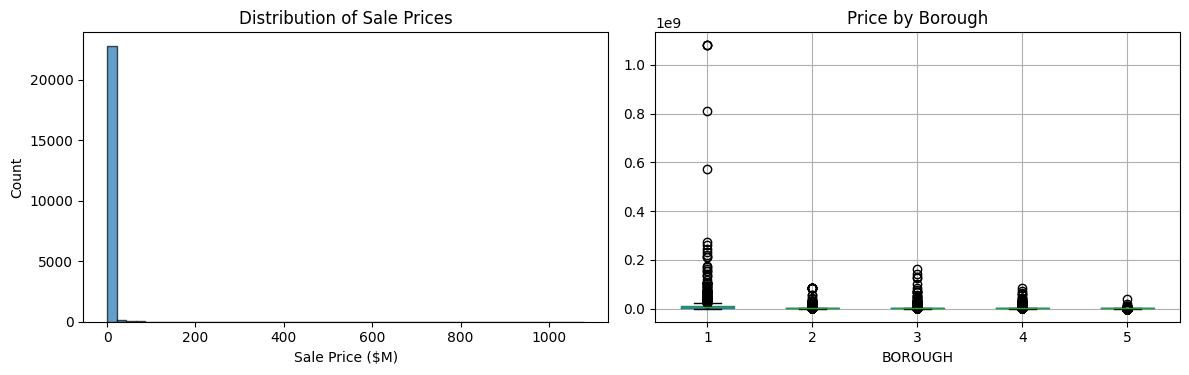

In [314]:
#Price distribution (histogram + boxplot)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(df["SALE PRICE"] / 1e6, bins=50, edgecolor="black", alpha=0.7)
axes[0].set_xlabel("Sale Price ($M)")
axes[0].set_ylabel("Count")
axes[0].set_title("Distribution of Sale Prices")
df.boxplot(column="SALE PRICE", by="BOROUGH", ax=axes[1])
axes[1].set_title("Price by Borough")
plt.suptitle("")
plt.tight_layout()
plt.show()

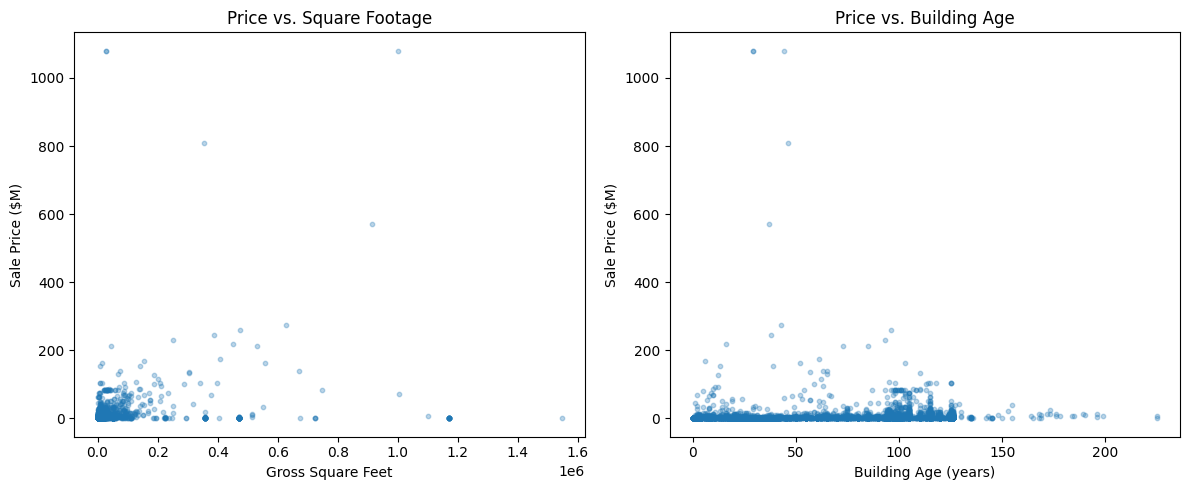

In [315]:
# Price vs. key features (scatter)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(df["GROSS SQUARE FEET"], df["SALE PRICE"] / 1e6, alpha=0.3, s=10)
axes[0].set_xlabel("Gross Square Feet")
axes[0].set_ylabel("Sale Price ($M)")
axes[0].set_title("Price vs. Square Footage")
axes[1].scatter(df["BUILDING_AGE"], df["SALE PRICE"] / 1e6, alpha=0.3, s=10)
axes[1].set_xlabel("Building Age (years)")
axes[1].set_ylabel("Sale Price ($M)")
axes[1].set_title("Price vs. Building Age")
plt.tight_layout()
plt.show()

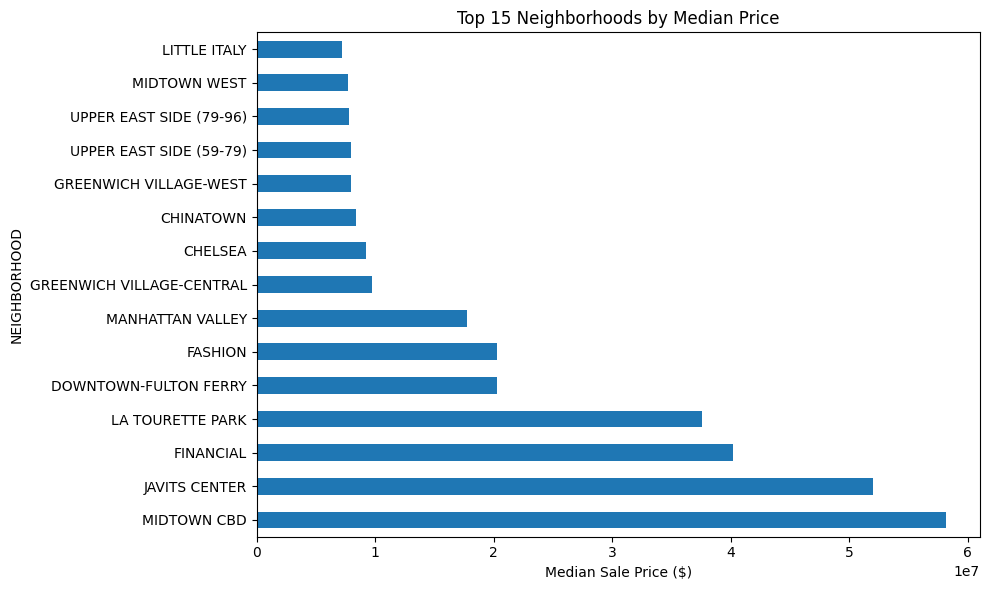

In [316]:
# Top neighborhoods by median price (bar chart)
top_n = df.groupby("NEIGHBORHOOD")["SALE PRICE"].median().nlargest(15)
top_n.plot(kind="barh", figsize=(10, 6))
plt.xlabel("Median Sale Price ($)")
plt.title("Top 15 Neighborhoods by Median Price")
plt.tight_layout()
plt.show()

In [317]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BUILDING CLASS AT PRESENT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,BUILDING_AGE
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,C4,10009.0,28.0,0.0,28.0,4542.0,18254.0,1900.0,2,C4,540000,125.0
7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,C4,10009.0,18.0,0.0,18.0,2404.0,6875.0,1900.0,2,C4,280000,125.0
8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,C7,10009.0,8.0,3.0,11.0,2364.0,7166.0,1900.0,2,C7,8800000,125.0
9,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,C4,10009.0,8.0,2.0,10.0,1919.0,7810.0,1900.0,2,C4,2000000,125.0
11,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,C4,10009.0,10.0,0.0,10.0,2369.0,6990.0,1900.0,2,C4,4000000,125.0


In [318]:
df = df.drop_duplicates()

In [319]:
# Aggressive price filter: residential sales between $100k and $5M only
# (avoids hidden outliers and $100M+ skew; first model focuses on typical residential range)
PRICE_MIN, PRICE_MAX = 100_000, 5_000_000
df = df[(df["SALE PRICE"] >= PRICE_MIN) & (df["SALE PRICE"] <= PRICE_MAX)].copy()
# Optional: restrict to buildings with residential units
df = df[df["RESIDENTIAL UNITS"] > 0].copy()
print(f"After price filter ($100k–$5M, residential): {len(df):,} rows")

After price filter ($100k–$5M, residential): 19,672 rows


In [320]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BUILDING CLASS AT PRESENT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,BUILDING_AGE
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,C4,10009.0,28.0,0.0,28.0,4542.0,18254.0,1900.0,2,C4,540000,125.0
7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,C4,10009.0,18.0,0.0,18.0,2404.0,6875.0,1900.0,2,C4,280000,125.0
9,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,C4,10009.0,8.0,2.0,10.0,1919.0,7810.0,1900.0,2,C4,2000000,125.0
11,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,C4,10009.0,10.0,0.0,10.0,2369.0,6990.0,1900.0,2,C4,4000000,125.0
116,1,CHELSEA,01 ONE FAMILY DWELLINGS,1,A4,10011.0,1.0,0.0,1.0,687.0,3363.0,1910.0,1,A4,4775000,115.0


## Phase 2 — Two-Headed Model (Aleatoric + Epistemic)

Architecture: shared Dense layers with Dropout (MC Dropout), two heads for mean (μ) and log-variance (σ²). Loss: Gaussian NLL. Target: log(SALE PRICE) for heteroscedastic NYC prices.

In [321]:
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seeds(42)

In [322]:
# Select features + target (log1p for stability)
target_col = "SALE PRICE"

num_cols = [
    "GROSS SQUARE FEET",
    "LAND SQUARE FEET",
    "BUILDING_AGE",
    "RESIDENTIAL UNITS",
    "COMMERCIAL UNITS",
    "TOTAL UNITS",
]

cat_cols = [
    "BOROUGH",
    "NEIGHBORHOOD",
    "BUILDING CLASS CATEGORY",
    "TAX CLASS AT PRESENT",
    "BUILDING CLASS AT PRESENT",
]

# Keep only columns we need and drop missing (should be minimal after your earlier cleaning)
model_df = df[num_cols + cat_cols + [target_col]].dropna().copy()

X = model_df[num_cols + cat_cols]
y = np.log1p(model_df[target_col].astype(float).values)

print("Rows for modeling:", len(model_df))
print("y (log1p) range:", float(y.min()), "to", float(y.max()))

Rows for modeling: 19672
y (log1p) range: 11.51293546492023 to 15.424948670398354


In [323]:
# Train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", len(X_train), "Test:", len(X_test))

Train: 15737 Test: 3935


In [324]:
# Preprocess: scale numeric + one-hot encode categoricals
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop",
    sparse_threshold=0.3,
)

X_train_p = preprocess.fit_transform(X_train)
X_test_p  = preprocess.transform(X_test)

print("Processed shapes:", X_train_p.shape, X_test_p.shape)

Processed shapes: (15737, 325) (3935, 325)


In [325]:
# Baseline model (strong + fast): Ridge regression
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train_p, y_train)

y_pred = ridge.predict(X_test_p)

print("Baseline (Ridge) on log1p(price):")
print(f"  R2:  {r2_score(y_test, y_pred):.4f}")
print(f"  MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"  RMSE:{np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")

# Also report dollars for interpretability
y_pred_dollars = np.expm1(y_pred)
y_test_dollars = np.expm1(y_test)

print("\nBaseline (Ridge) in dollars:")
print(f"  MAE:  ${mean_absolute_error(y_test_dollars, y_pred_dollars):,.0f}")
print(f"  RMSE: ${np.sqrt(mean_squared_error(y_test_dollars, y_pred_dollars)):,.0f}")

Baseline (Ridge) on log1p(price):
  R2:  0.4769
  MAE: 0.2648
  RMSE:0.4011

Baseline (Ridge) in dollars:
  MAE:  $299,407
  RMSE: $516,979


In [326]:
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train_raw.reshape(-1, 1)).astype(np.float32)
y_test_scaled  = scaler_y.transform(y_test_raw.reshape(-1, 1)).astype(np.float32)

# Range in dollars used to scale variance back (same as professor)
y_range = scaler_y.data_range_[0]

print("y_train_scaled range:", float(y_train_scaled.min()), "to", float(y_train_scaled.max()))
print("y_range ($):", y_range)

y_train_scaled range: 0.0 to 1.0
y_range ($): 2489999.0


In [327]:
# Convert sparse matrix to dense only if needed for TF
import scipy.sparse as sp

def to_dense_if_sparse(Xs):
    return Xs.toarray() if sp.issparse(Xs) else Xs

X_train_tf = to_dense_if_sparse(X_train_p).astype(np.float32)
X_test_tf  = to_dense_if_sparse(X_test_p).astype(np.float32)
y_train_tf = y_train.astype(np.float32)
y_test_tf  = y_test.astype(np.float32)

print("TF shapes:", X_train_tf.shape, X_test_tf.shape)

TF shapes: (15737, 325) (3935, 325)


In [329]:
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.callbacks import EarlyStopping

tf.keras.backend.clear_session()

def aleatoric_loss(y_true, y_pred):
    mu = y_pred[:, 0:1]
    sigma_sq = y_pred[:, 1:2]  # already positive because softplus
    eps = 1e-6
    return tf.reduce_mean(
        0.5 * tf.math.log(sigma_sq + eps) +
        0.5 * tf.square(y_true - mu) / (sigma_sq + eps)
    )

def make_combined_model(n_features, dropout_rate=0.2):
    inputs = Input(shape=(n_features,))
    x = Dense(128, activation="relu")(inputs)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x, training=True)   # KEEP ON for epistemic

    x = Dense(64, activation="relu")(x)
    x = BatchNormalization()(x)

    mu = Dense(1, name="mu")(x)
    sigma_sq = Dense(1, activation="softplus", name="sigma_sq")(x)

    return tf.keras.Model(inputs=inputs, outputs=Concatenate()([mu, sigma_sq]))

model = make_combined_model(X_train_tf.shape[1], dropout_rate=0.2)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=aleatoric_loss)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 325)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     41,728 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mu (Dense)          │ (None, 1)         │         65 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sigma_sq (Dense)    │ (None, 1)         │         65 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2)         │          0 │ mu[0][0],         │
│ (Concatenate)       │                   │            │ sigma_sq[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 50,882 (198.76 KB)

 Trainable params: 50,498 (197.26 KB)

 Non-trainable params: 384 (1.50 KB)

In [330]:
history = model.fit(
    X_train_tf, y_train_scaled,
    epochs=300,
    batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=15, restore_best_weights=True)],
    verbose=1
)

Epoch 1/300


2026-02-24 23:44:04.886852: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0749 - val_loss: -0.4382
Epoch 2/300
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.6196 - val_loss: -0.9640
Epoch 3/300
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.9618 - val_loss: -1.0372
Epoch 4/300
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -1.0595 - val_loss: -1.0621
Epoch 5/300
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -1.1003 - val_loss: -1.0509
Epoch 6/300
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -1.1152 - val_loss: -1.0539
Epoch 7/300
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -1.1371 - val_loss: -1.0432
Epoch 8/300
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -1.1465 - val_loss: -1.0461
Epoch 9/300
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -1.1565 - val_loss: -1.0280
Epoch 10/300
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -1.1654 - val_loss: -1.0115
Epoch 11/300
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -1.1805 - val_loss: -0.5580
Epoch 12/300
394/394 ━━━━━━━━━━━

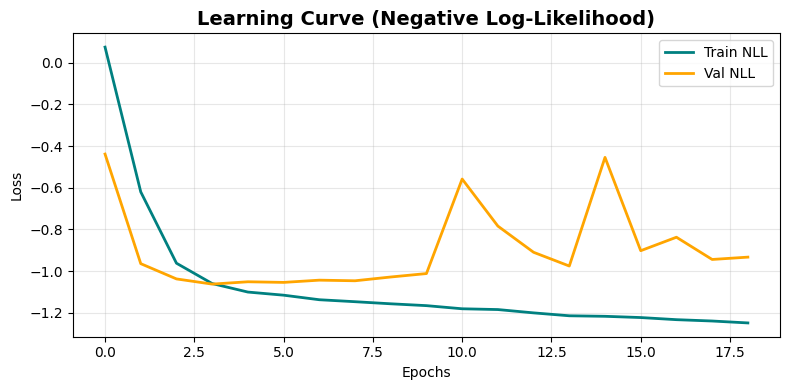

In [331]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(history.history["loss"], label="Train NLL", color="teal", lw=2)
ax.plot(history.history["val_loss"], label="Val NLL", color="orange", lw=2)
ax.set_title("Learning Curve (Negative Log-Likelihood)", fontsize=14, fontweight="bold")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [332]:
T = 100
preds = np.stack([model(X_test, training=True).numpy() for _ in range(T)])
all_mu_log = preds[:, :, 0]
all_sigma_sq_log = preds[:, :, 1]

mu_mean_log = all_mu_log.mean(axis=0)
mu_mean_dollars = np.exp(mu_mean_log)

epistemic_var_log = all_mu_log.var(axis=0)
epistemic_std_log = np.sqrt(epistemic_var_log)
epistemic_std_dollars = mu_mean_dollars * epistemic_std_log

aleatoric_var_log = all_sigma_sq_log.mean(axis=0)
aleatoric_std_log = np.sqrt(aleatoric_var_log)
aleatoric_std_dollars = mu_mean_dollars * aleatoric_std_log

total_std_dollars = np.sqrt(epistemic_std_dollars**2 + aleatoric_std_dollars**2)

r2 = r2_score(y_test_raw, mu_mean_dollars)
print(f"R2 (dollars): {r2:.4f}")
print(f"Epistemic std: mean=${epistemic_std_dollars.mean():,.0f}, max=${epistemic_std_dollars.max():,.0f}")
print(f"Aleatoric std:  mean=${aleatoric_std_dollars.mean():,.0f}, max=${aleatoric_std_dollars.max():,.0f}")

ValueError: Input 0 with name 'input_layer' of layer 'functional' is incompatible with the layer: expected shape=(None, 325), found shape=(3935, 11)

In [266]:
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.callbacks import EarlyStopping

tf.keras.backend.clear_session()

def make_uncertainty_model_simple(n_features, dropout_rate=0.1):
    inp = Input(shape=(n_features,))
    x = Dense(128, activation="relu")(inp)
    x = Dropout(dropout_rate)(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout_rate)(x)
    mu = Dense(1, name="mu")(x)
    raw_var = Dense(1, name="raw_var")(x)
    out = Concatenate()([mu, raw_var])
    return tf.keras.Model(inp, out)

model = make_uncertainty_model_simple(X_train_tf.shape[1], dropout_rate=0.1)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=gaussian_nll_var_with_mse(alpha=0.5),
)

In [267]:
# Train
history = model.fit(
    X_train_tf, y_train_tf,
    validation_split=0.2,
    epochs=250,
    batch_size=128,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1
)

Epoch 1/250


2026-02-24 23:22:32.226832: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 163.0007 - val_loss: 116.0386
Epoch 2/250
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 83.8029 - val_loss: 52.0238
Epoch 3/250
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31.9192 - val_loss: 14.1996
Epoch 4/250
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10.6355 - val_loss: 6.5044
Epoch 5/250
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5718 - val_loss: 5.4357
Epoch 6/250
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4066 - val_loss: 4.7174
Epoch 7/250
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6593 - val_loss: 4.1670
Epoch 8/250
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9992 - val_loss: 3.7326
Epoch 9/250
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.5865 - val_loss: 3.3839
Epoch 10/250
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.2336 - val_loss: 3.1068
Epoch 11/250
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9152 - val_loss: 2.8706
Epoch 12/250
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.6832

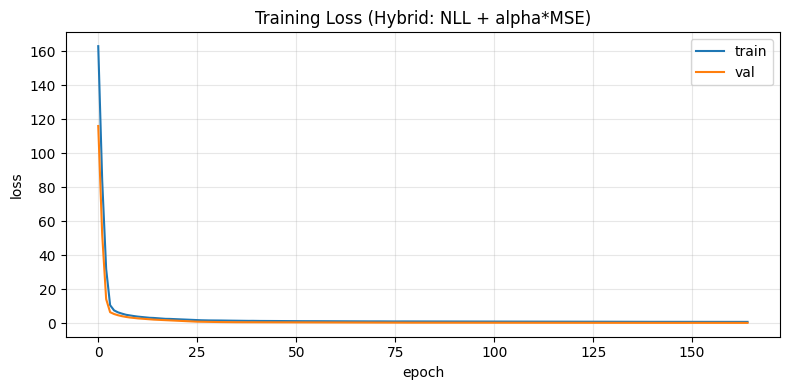

In [268]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Training Loss (Hybrid: NLL + alpha*MSE)")
plt.xlabel("epoch"); plt.ylabel("loss")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout(); plt.show()

In [232]:
pred_det = model(X_test_tf, training=False).numpy()
mu_det = pred_det[:, 0]   # log1p

print("Deterministic NN (dropout OFF) on log1p(price):")
print(f"  R2:   {r2_score(y_test_tf, mu_det):.4f}")
print(f"  MAE:  {mean_absolute_error(y_test_tf, mu_det):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test_tf, mu_det)):.4f}")

pred_det_dollars = np.expm1(mu_det)
true_dollars = np.expm1(y_test_tf)
print("\nIn dollars:")
print(f"  MAE:  ${mean_absolute_error(true_dollars, pred_det_dollars):,.0f}")
print(f"  RMSE: ${np.sqrt(mean_squared_error(true_dollars, pred_det_dollars)):,.0f}")

Deterministic NN (dropout OFF) on log1p(price):
  R2:   -0.0645
  MAE:  0.4186
  RMSE: 0.5722

In dollars:
  MAE:  $464,818
  RMSE: $784,330


In [239]:
# Prediction intervals + coverage (interval size analysis)
# Total predictive variance ≈ epistemic + aleatoric
total_var = epi_var + ale_var
total_std = np.sqrt(total_var)

# 90% interval in log space (z ~ 1.645)
z = 1.645
lower_log = mu_mean - z * total_std
upper_log = mu_mean + z * total_std

# Convert to dollars
lower = np.expm1(lower_log)
upper = np.expm1(upper_log)
pred = np.expm1(mu_mean)
true = np.expm1(y_test_tf)

coverage = np.mean((true >= lower) & (true <= upper))
avg_width = np.mean(upper - lower)

print("90% interval diagnostics:")
print(f"  Coverage: {coverage:.3f} (target ~0.90)")
print(f"  Avg width: ${avg_width:,.0f}")

# Plot width vs absolute error (inspect where uncertainty is useful)
abs_err = np.abs(true - pred)
fig, ax = plt.subplots(figsize=(7,4))
ax.scatter(upper - lower, abs_err, alpha=0.3)
ax.set_xlabel("Interval width ($)")
ax.set_ylabel("Absolute error ($)")
ax.set_title("Interval Width vs Error (90% PI)")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ValueError: operands could not be broadcast together with shapes (3935,) (3957,) 

In [144]:
# Biggest misses & best successes (top/bottom errors) + outlier inspection
residual = true - pred
abs_err = np.abs(residual)

tmp = X_test.copy()
tmp = tmp.reset_index(drop=True)
tmp["true_price"] = true
tmp["pred_price"] = pred
tmp["abs_error"] = abs_err
tmp["pi_width"] = (upper - lower)

print("Top 10 biggest misses:")
display(tmp.sort_values("abs_error", ascending=False).head(10))

print("\nTop 10 best successes:")
display(tmp.sort_values("abs_error", ascending=True).head(10))

Top 10 biggest misses:


,GROSS SQUARE FEET,LAND SQUARE FEET,BUILDING_AGE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BUILDING CLASS AT PRESENT,true_price,pred_price,abs_error,pi_width
2609,1360.0,918.0,126.0,2.0,0.0,2.0,1,GREENWICH VILLAGE-WEST,02 TWO FAMILY DWELLINGS,1,B9,5000000.0,791439.312500,4208560.50,8.024914e+06
3001,4472.0,2100.0,120.0,2.0,0.0,2.0,3,PARK SLOPE,02 TWO FAMILY DWELLINGS,1,B1,4964999.5,815373.250000,4149626.25,5.822593e+06
2711,3680.0,1351.0,12.0,2.0,0.0,2.0,3,DOWNTOWN-FULTON MALL,02 TWO FAMILY DWELLINGS,1,B1,4224999.0,78809.929688,4146189.00,5.347133e+05
1484,3566.0,2000.0,124.0,3.0,0.0,3.0,3,BOERUM HILL,03 THREE FAMILY DWELLINGS,1,C0,4995000.5,855526.437500,4139474.00,6.777074e+06
24,5436.0,1839.0,125.0,10.0,0.0,10.0,1,UPPER WEST SIDE (79-96),07 RENTALS - WALKUP APARTMENTS,2B,C5,4949998.0,836201.625000,4113796.50,6.849298e+06
1620,2850.0,2500.0,125.0,4.0,0.0,4.0,3,COBBLE HILL,07 RENTALS - WALKUP APARTMENTS,2A,C3,4849999.0,738364.812500,4111634.25,4.910890e+06
2001,3672.0,2000.0,124.0,2.0,0.0,2.0,3,PARK SLOPE,02 TWO FAMILY DWELLINGS,1,B3,5000000.0,931101.312500,4068898.75,7.236182e+06
3090,4008.0,1875.0,124.0,2.0,0.0,2.0,3,PARK SLOPE,02 TWO FAMILY DWELLINGS,1,B3,4949998.0,893477.062500,4056521.00,6.420194e+06
2760,1977.0,659.0,126.0,2.0,0.0,2.0,1,GREENWICH VILLAGE-WEST,02 TWO FAMILY DWELLINGS,1,B1,4749999.5,699285.062500,4050714.50,6.083155e+06
3543,9660.0,2554.0,115.0,10.0,1.0,11.0,1,UPPER WEST SIDE (79-96),07 RENTALS - WALKUP APARTMENTS,2,C7,4800000.0,753539.062500,4046461.00,6.734771e+06



Top 10 best successes:


,GROSS SQUARE FEET,LAND SQUARE FEET,BUILDING_AGE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BUILDING CLASS AT PRESENT,true_price,pred_price,abs_error,pi_width
2495,2120.0,2050.0,85.0,3.0,0.0,3.0,3,FLATBUSH-NORTH,03 THREE FAMILY DWELLINGS,1,C0,8.266141e+05,8.266141e+05,0.0000,6249726.5
1295,1040.0,2500.0,70.0,1.0,0.0,1.0,4,FLUSHING-SOUTH,01 ONE FAMILY DWELLINGS,1,A5,9.249997e+05,9.251647e+05,165.0000,6538813.0
3307,970.0,1500.0,100.0,1.0,0.0,1.0,4,ELMHURST,01 ONE FAMILY DWELLINGS,1,A5,8.899996e+05,8.894201e+05,579.5000,7433120.5
1741,1632.0,2208.0,100.0,1.0,0.0,1.0,4,BELLEROSE,01 ONE FAMILY DWELLINGS,1,A1,8.199999e+05,8.205928e+05,592.9375,6737684.5
112,1296.0,2520.0,65.0,1.0,0.0,1.0,4,FLUSHING-NORTH,01 ONE FAMILY DWELLINGS,1,A5,9.500000e+05,9.507514e+05,751.3750,7065009.0
3876,1080.0,2219.0,105.0,1.0,0.0,1.0,4,CORONA,01 ONE FAMILY DWELLINGS,1,A1,9.358756e+05,9.351138e+05,761.8750,7159219.0
2104,2480.0,2151.0,94.0,2.0,1.0,3.0,4,QUEENS VILLAGE,02 TWO FAMILY DWELLINGS,1,S2,9.749998e+05,9.758566e+05,856.7500,7771982.5
1825,1604.0,2406.0,95.0,1.0,0.0,1.0,4,SOUTH OZONE PARK,01 ONE FAMILY DWELLINGS,1,A1,8.600002e+05,8.608889e+05,888.6875,6273479.5
1515,3896.0,6000.0,115.0,3.0,0.0,3.0,3,CANARSIE,03 THREE FAMILY DWELLINGS,1,C0,1.100000e+06,1.100918e+06,917.2500,7424840.5
77,2016.0,5360.0,126.0,2.0,0.0,2.0,5,ARROCHAR,02 TWO FAMILY DWELLINGS,1,B1,7.200001e+05,7.190498e+05,950.3750,5497147.5


## Phase 4 — Uncertainty & SHAP Analysis

Compute epistemic (MC Dropout) and aleatoric (learned variance) uncertainty, interval coverage, and outlier inspection.

In [ ]:
# X_test_tf (shape [N, 326]), y_test_tf (log1p target), and also y_test_dollars = np.expm1(y_test_tf)
y_test_dollars = np.expm1(y_test_tf)

T = 50

# MC Dropout forward passes 
preds = np.stack([model(X_test_tf, training=True).numpy() for _ in range(T)], axis=0)  # [T, N, 2]

# Head outputs
all_mu = preds[:, :, 0]          # mu in log1p(price) space
all_raw_var = preds[:, :, 1]     # raw var parameter (NOT variance yet)

# Convert raw_var -> variance via softplus + floor (must match training loss)
all_var = np.log1p(np.exp(all_raw_var)) + 1e-4   # [T, N]  softplus

# Epistemic uncertainty = variance of mu across MC passes (log space)
epistemic_var_log = all_mu.var(axis=0)           # [N]
epistemic_std_log = np.sqrt(epistemic_var_log)

# Aleatoric uncertainty = mean predicted variance (log space)
aleatoric_var_log = all_var.mean(axis=0)         # [N]
aleatoric_std_log = np.sqrt(aleatoric_var_log)

# Mean prediction in log space
mu_mean_log = all_mu.mean(axis=0)                # [N]

# Convert mean prediction to dollars
mu_mean_dollars = np.expm1(mu_mean_log)          # because target is log1p(price)

# Convert log-space std -> dollar-space approx (delta method)
# If y = expm1(z), dy/dz = exp(z) = y+1
jac = mu_mean_dollars + 1.0
epistemic_std_dollars = jac * epistemic_std_log
aleatoric_std_dollars = jac * aleatoric_std_log

# Total predictive std (approx)
total_std_dollars = np.sqrt(epistemic_std_dollars**2 + aleatoric_std_dollars**2)

print("Uncertainty (dollars) - sample stats:")
print(f"  Epistemic std:  mean=${epistemic_std_dollars.mean():,.0f}, max=${epistemic_std_dollars.max():,.0f}")
print(f"  Aleatoric std:  mean=${aleatoric_std_dollars.mean():,.0f}, max=${aleatoric_std_dollars.max():,.0f}")
print(f"  Total std:      mean=${total_std_dollars.mean():,.0f}, max=${total_std_dollars.max():,.0f}")

Uncertainty (dollars) - sample stats:
  Epistemic std:  mean=$722,157, max=$2,251,608
  Aleatoric std:  mean=$898,852, max=$3,057,747
  Total std:      mean=$1,154,453, max=$3,742,359


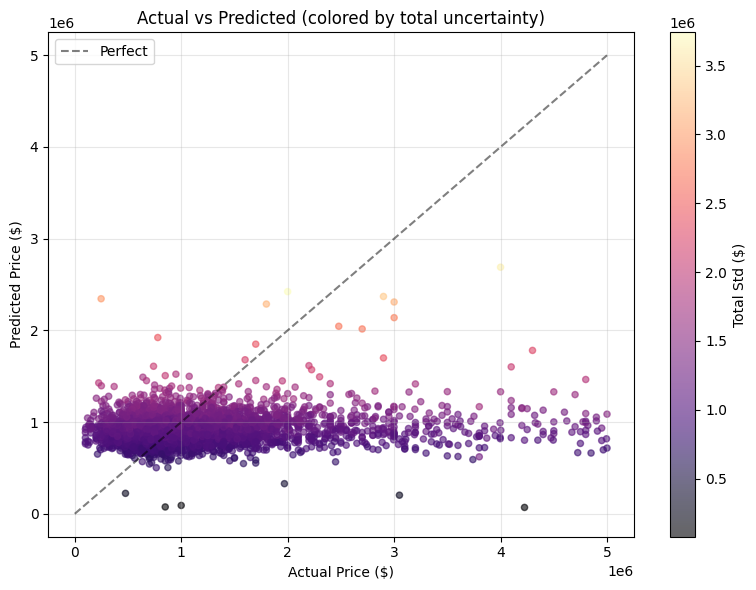

In [150]:
# Actual vs Predicted scatter (colored by total uncertainty)

fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(
    y_test_dollars,
    mu_mean_dollars,
    c=total_std_dollars,
    cmap="magma",
    alpha=0.6,
    s=20,
)
maxv = max(y_test_dollars.max(), mu_mean_dollars.max())
ax.plot([0, maxv], [0, maxv], "k--", alpha=0.5, label="Perfect")
ax.set_xlabel("Actual Price ($)")
ax.set_ylabel("Predicted Price ($)")
ax.set_title("Actual vs Predicted (colored by total uncertainty)")
plt.colorbar(sc, ax=ax, label="Total Std ($)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

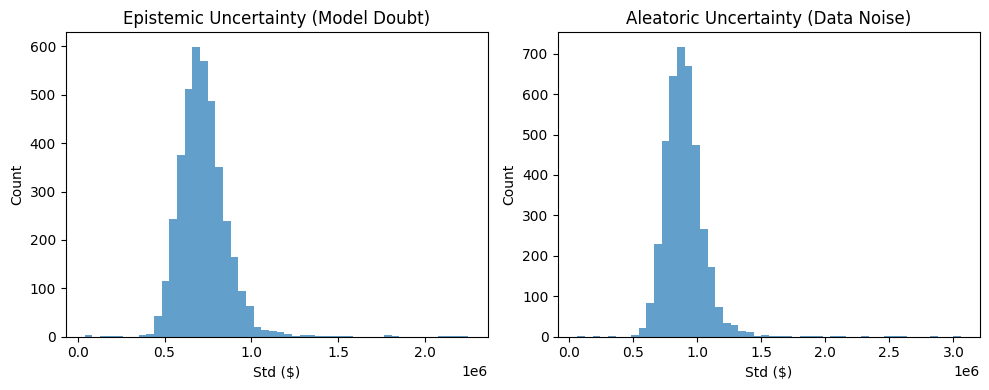

In [151]:
# Uncertainty histograms: epistemic vs aleatoric

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(epistemic_std_dollars, bins=50, alpha=0.7)
axes[0].set_xlabel("Std ($)")
axes[0].set_ylabel("Count")
axes[0].set_title("Epistemic Uncertainty (Model Doubt)")

axes[1].hist(aleatoric_std_dollars, bins=50, alpha=0.7)
axes[1].set_xlabel("Std ($)")
axes[1].set_ylabel("Count")
axes[1].set_title("Aleatoric Uncertainty (Data Noise)")

plt.tight_layout()
plt.show()

In [152]:
# 95% interval coverage (Gaussian approximation in dollar space)

z = 1.96
lower = mu_mean_dollars - z * total_std_dollars
upper = mu_mean_dollars + z * total_std_dollars

# prices can't be negative
lower = np.maximum(lower, 0)

hits = (y_test_dollars >= lower) & (y_test_dollars <= upper)
coverage = hits.mean()
avg_width = np.mean(upper - lower)

print(f"95% Gaussian interval coverage: {coverage:.2%} (target: 95%)")
print(f"Average interval width: ${avg_width:,.0f}")

95% Gaussian interval coverage: 96.69% (target: 95%)
Average interval width: $3,188,760


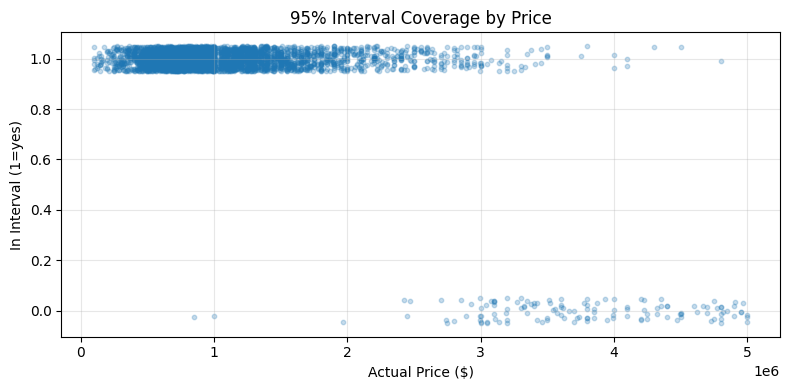

In [153]:
# Plot hit rate vs actual price (jittered)

fig, ax = plt.subplots(figsize=(8, 4))
jitter = np.random.uniform(-0.05, 0.05, size=len(hits))
ax.scatter(y_test_dollars, hits.astype(float) + jitter, alpha=0.25, s=10)
ax.set_xlabel("Actual Price ($)")
ax.set_ylabel("In Interval (1=yes)")
ax.set_title("95% Interval Coverage by Price")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Unpredictable luxury cluster: 78 properties (high price + high aleatoric uncertainty)
  Price P90: $2,000,000
  Aleatoric std P90: $1,071,116


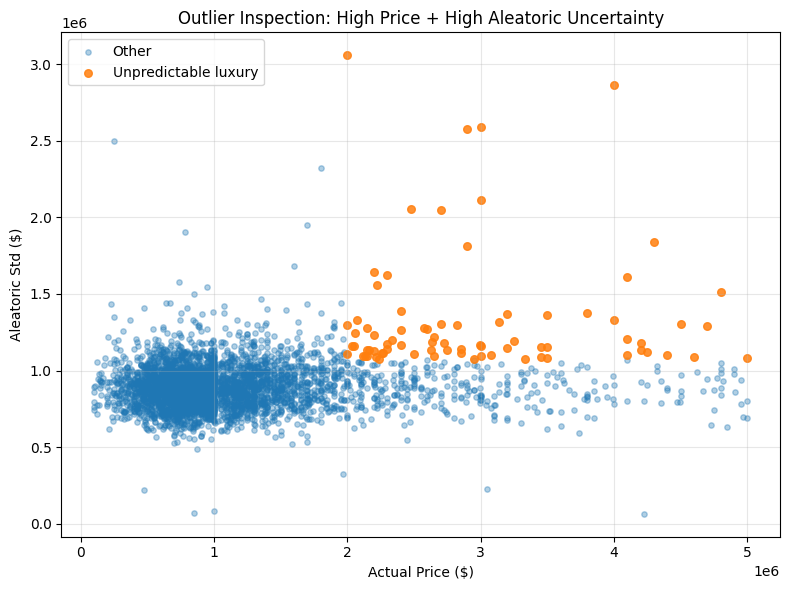

In [154]:
# Outlier inspection: high price AND high aleatoric uncertainty

price_p90 = np.percentile(y_test_dollars, 90)
aleatoric_p90 = np.percentile(aleatoric_std_dollars, 90)

unpredictable_luxury = (y_test_dollars >= price_p90) & (aleatoric_std_dollars >= aleatoric_p90)
n_outliers = int(unpredictable_luxury.sum())

print(f"Unpredictable luxury cluster: {n_outliers} properties (high price + high aleatoric uncertainty)")
print(f"  Price P90: ${price_p90:,.0f}")
print(f"  Aleatoric std P90: ${aleatoric_p90:,.0f}")

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(
    y_test_dollars[~unpredictable_luxury],
    aleatoric_std_dollars[~unpredictable_luxury],
    alpha=0.35,
    s=15,
    label="Other",
)
ax.scatter(
    y_test_dollars[unpredictable_luxury],
    aleatoric_std_dollars[unpredictable_luxury],
    alpha=0.85,
    s=30,
    label="Unpredictable luxury",
)
ax.set_xlabel("Actual Price ($)")
ax.set_ylabel("Aleatoric Std ($)")
ax.set_title("Outlier Inspection: High Price + High Aleatoric Uncertainty")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### SHAP Interpretation

Three predictor wrappers for SHAP: price (mean), epistemic std, aleatoric std. Use KernelExplainer for each.

In [157]:
import shap
import numpy as np

# Use the same matrices your NN uses
# X_train_tf, X_test_tf already are (N, 326) float32
X_bg = shap.sample(X_train_tf, 100, random_state=42)   # (100, 326)
X_subset_tf = X_test_tf[:40]                           # (40, 326)

print(X_bg.shape, X_subset_tf.shape)

(100, 326) (40, 326)


In [158]:
def predict_mean_final(x_np):
    preds = model(x_np, training=False).numpy()
    mu = preds[:, 0]               # log1p(price)
    return np.expm1(mu)            # dollars

def predict_epistemic_final(x_np, T=50):
    preds = np.stack([model(x_np, training=True).numpy() for _ in range(T)], axis=0)
    mu = preds[:, :, 0]            # [T, N] log1p
    mu_dollars = np.expm1(mu)
    return mu_dollars.std(axis=0)  # [N] dollars std

def predict_aleatoric_final(x_np):
    preds = model(x_np, training=False).numpy()
    mu = preds[:, 0]               # log1p
    raw_var = preds[:, 1]          # raw var head

    # convert raw_var -> var in log space (must match training)
    var_log = np.log1p(np.exp(raw_var)) + 1e-4
    std_log = np.sqrt(var_log)

    mu_dollars = np.expm1(mu)
    jac = mu_dollars + 1.0         # d(expm1)/dz = exp(z) = y+1
    return jac * std_log           # dollars std (delta method)

SHAP beeswarm: Price (Mean)...


100%|██████████| 40/40 [00:01<00:00, 39.16it/s]


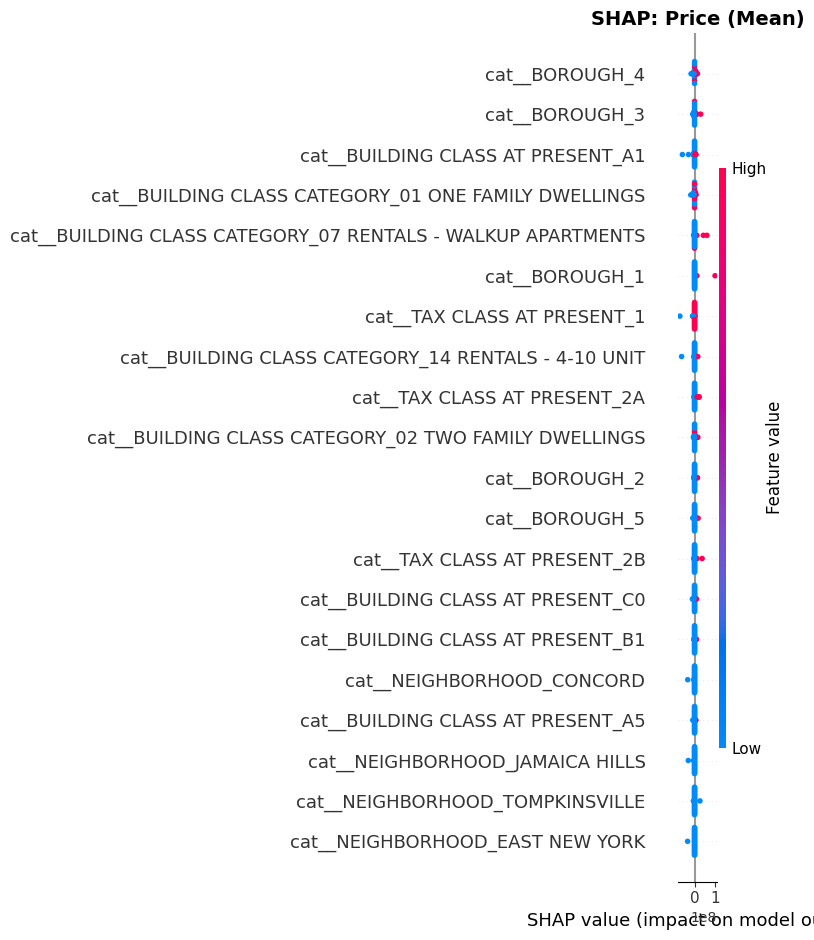

SHAP beeswarm: Model Doubt (Epistemic)...


100%|██████████| 40/40 [00:36<00:00,  1.10it/s]


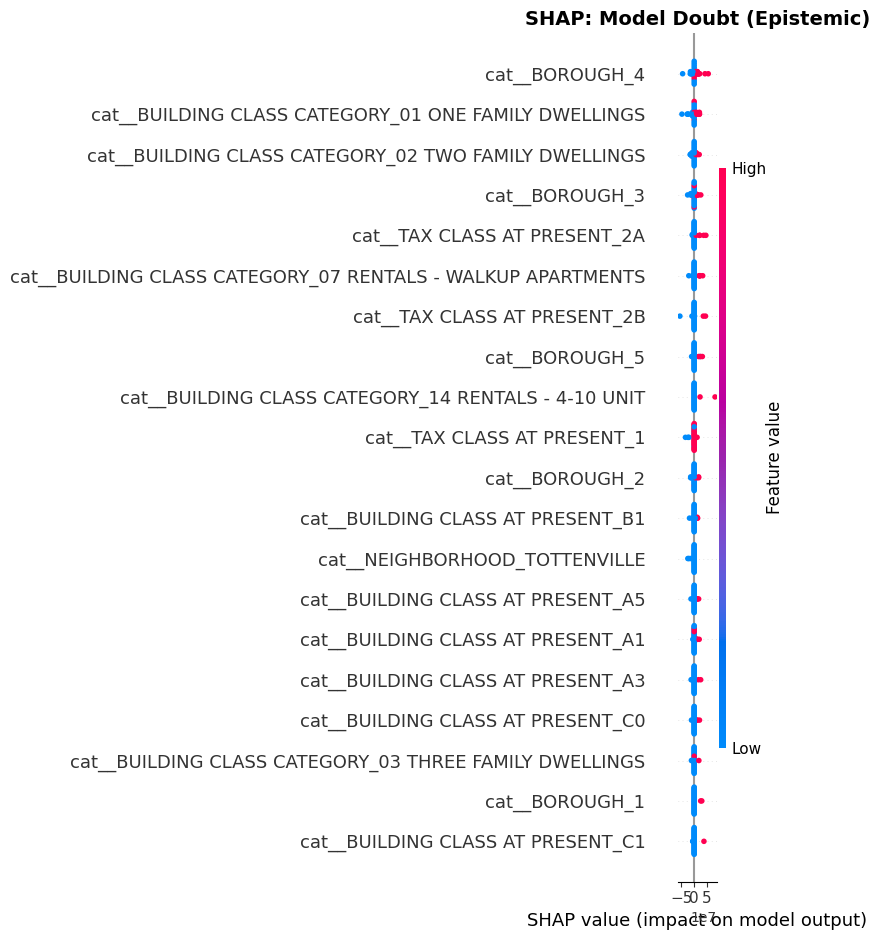

SHAP beeswarm: Data Noise (Aleatoric)...


100%|██████████| 40/40 [00:00<00:00, 42.78it/s]


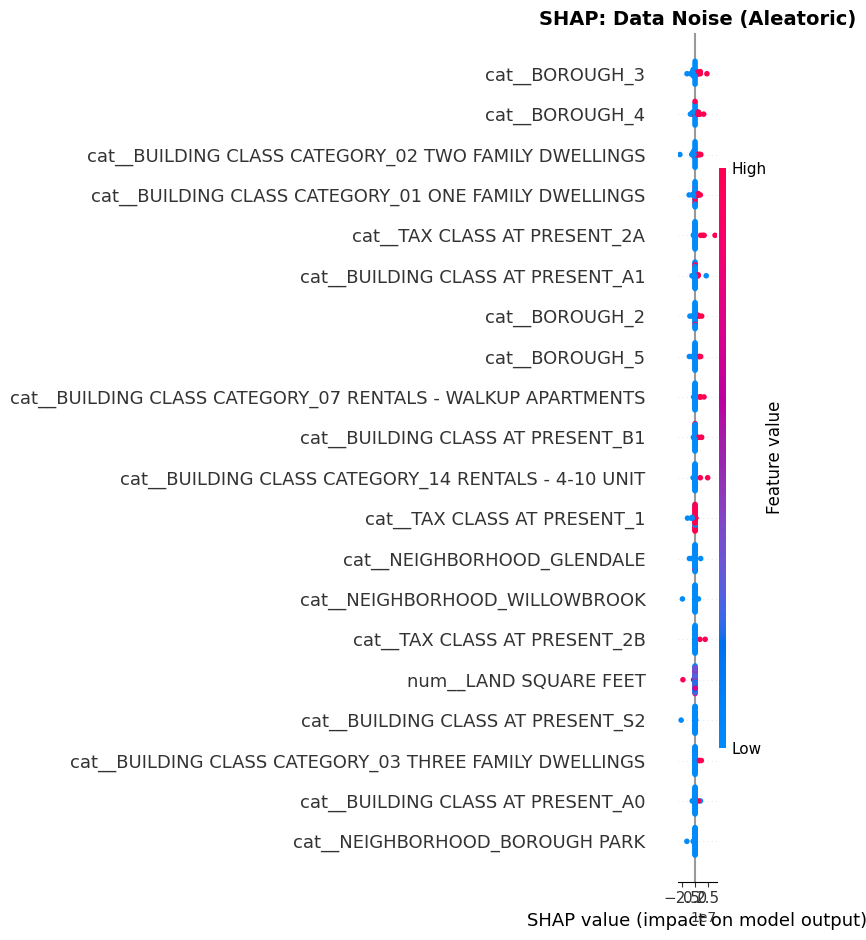

In [159]:
import matplotlib.pyplot as plt

# feature names in 326-dim space (important!)
feature_names = preprocess.get_feature_names_out()

surgical_predictors = {
    "Price (Mean)": predict_mean_final,
    "Model Doubt (Epistemic)": predict_epistemic_final,
    "Data Noise (Aleatoric)": predict_aleatoric_final,
}

for title, func in surgical_predictors.items():
    print(f"SHAP beeswarm: {title}...")

    explainer = shap.KernelExplainer(func, X_bg)
    sv = explainer.shap_values(X_subset_tf, nsamples=200)  # lower for speed

    if isinstance(sv, list):
        sv = sv[0]

    plt.figure(figsize=(10, 6))
    shap.summary_plot(sv, X_subset_tf, feature_names=feature_names, show=False)
    plt.title(f"SHAP: {title}", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()

In [300]:
# Dependence plots for affluence_score and GROSS SQUARE FEET
for title, func in surgical_predictors.items():
    explainer = shap.KernelExplainer(func, background)
    sv = explainer.shap_values(X_subset, nsamples=500)
    if isinstance(sv, list):
        sv = sv[0]
    exp = shap.Explanation(values=sv, data=X_subset, feature_names=feature_names, base_values=explainer.expected_value)
    for feat in ["affluence_score", "GROSS SQUARE FEET"]:
        if feat in feature_names:
            idx = feature_names.index(feat)
            plt.figure(figsize=(8, 5))
            shap.plots.scatter(exp[:, feat], color=exp, show=False)
            plt.title(f"{title} vs {feat}")
            plt.tight_layout()
            plt.show()

Provided model function fails when applied to the provided data set.


ValueError: Input 0 with name 'input_layer' of layer 'functional' is incompatible with the layer: expected shape=(None, 325), found shape=(100, 11)

In [ ]:
# Waterfall plots for the most uncertain house
max_unc_idx = np.argmax(total_std_dollars)
for title, func in surgical_predictors.items():
    explainer = shap.KernelExplainer(func, background)
    sv = explainer.shap_values(X_test[max_unc_idx : max_unc_idx + 1], nsamples=500)
    if isinstance(sv, list):
        sv = sv[0]
    exp_single = shap.Explanation(
        values=sv[0],
        base_values=explainer.expected_value,
        data=X_test[max_unc_idx],
        feature_names=feature_names,
    )
    plt.figure(figsize=(10, 6))
    shap.plots.waterfall(exp_single, show=False)
    plt.title(f"Waterfall: {title} for Most Uncertain Property", fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
# Four-quadrant SHAP magnitude x uncertainty magnitude
targets = {"mean": predict_mean_final, "epistemic": predict_epistemic_final, "aleatoric": predict_aleatoric_final}
sv_results = {}
for name, func in targets.items():
    explainer = shap.KernelExplainer(func, background)
    sv = explainer.shap_values(X_subset, nsamples=500)
    if isinstance(sv, list):
        sv = sv[0]
    sv_results[name] = sv

shap_mag = np.abs(sv_results["mean"]).sum(axis=1)
unc_mag = np.abs(sv_results["epistemic"]).sum(axis=1) + np.abs(sv_results["aleatoric"]).sum(axis=1)
med_shap, med_unc = np.median(shap_mag), np.median(unc_mag)
quadrant = np.where(shap_mag >= med_shap, 1, 0) + np.where(unc_mag >= med_unc, 2, 0)
labels = {0: "Boring but Reliable", 1: "Confident Signal", 2: "Uncertain & Uninformative", 3: "Strong Claim, Low Confidence"}

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for q, lbl in labels.items():
    mask = quadrant == q
    ax.scatter(shap_mag[mask], unc_mag[mask], alpha=0.6, label=lbl, s=40)
ax.axvline(med_shap, color="gray", linestyle="--", alpha=0.5)
ax.axhline(med_unc, color="gray", linestyle="--", alpha=0.5)
ax.set_xlabel("|SHAP| (Price Impact)")
ax.set_ylabel("|SHAP| (Uncertainty Impact)")
ax.set_title("Four-Quadrant: SHAP Magnitude vs Uncertainty Magnitude")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()